In [37]:
import os, re
import dill
import random
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

In [70]:
from sklearn.model_selection import train_test_split
from keras.models import Sequential, load_model
from keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, Dropout
from keras.losses import categorical_crossentropy
from keras.optimizers import adam, sgd
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint

## Load Data
* ### prep original data: create df for path and label

In [4]:
# encode label
CATEGORIES = {
    'cardboard': 0,
    'glass': 1,
    'metal': 2,
    'paper': 3,
    'plastic': 4,
    'trash': 5
}

In [47]:
# create df
img_path = os.path.join(os.getcwd(), "data/raw_data/resize-mixed")
names = [f.split(".")[0] for f in os.listdir(img_path) if any(c.isdigit() for c in f)]
labels = [re.sub(r'\d+', '', name) for name in names]
label_codes = [CATEGORIES[l] for l in labels]
paths = [os.path.join(img_path, f+".jpg") for f in names]
dict_df = pd.DataFrame(zip(names, paths, labels, label_codes), columns=['name','path', 'label_name', 'label_code'], dtype=str)
dict_df.head()

,name,path,label_name,label_code
0,metal296,/Users/loaner/Documents/github/trash-classifie...,metal,2
1,plastic391,/Users/loaner/Documents/github/trash-classifie...,plastic,4
2,cardboard233,/Users/loaner/Documents/github/trash-classifie...,cardboard,0
3,cardboard227,/Users/loaner/Documents/github/trash-classifie...,cardboard,0
4,plastic385,/Users/loaner/Documents/github/trash-classifie...,plastic,4


total sample size: 2527
{'cardboard': 403, 'glass': 501, 'metal': 410, 'paper': 594, 'plastic': 482, 'trash': 137}


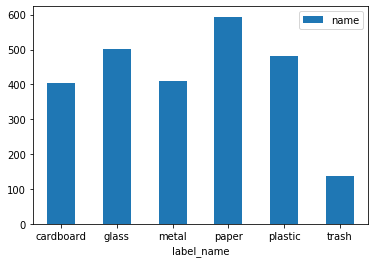

In [44]:
# sanity check
class_ct = dict_df.groupby(dict_df['label_name']).count()
print("total sample size: %d" % len(dict_df))
print(class_ct['name'].to_dict())
class_ct.reset_index().plot.bar(x='label_name', y='name', rot=0)

* ### Train test split with data augmentation

In [66]:
# image augmentation 
def rotate(image_array: np.ndarray):
    '''rotate image with a random degree (between left_degree and right_degree)'''
    degree_limit = 30
    rotate_degree = random.uniform(-degree_limit, degree_limit)
    return skimage.transform.rotate(image_array, rotate_degree)*255

def add_noise(image_array: np.ndarray):
    '''add noise to image'''
    return skimage.util.random_noise(image_array)*255

def hor_flip(image_array: np.ndarray):
    '''flipping pixels horizontally'''
    return image_array[:, ::-1]

def ver_flip(image_array: np.ndarray):
    '''flipping pixels vertically'''
    return image_array[::-1, :]

transform_methods = [rotate, add_noise, hor_flip, ver_flip]

In [68]:
def create_more_trash(target_num, base_file_paths, count_for_name):
    num_transformed = 0
    aug_img_df = pd.DataFrame(columns=dict_df.columns)
    
    base_folder = os.path.join('data/raw_data/resized', 'trash')
    aug_path = 'data/raw_data/aug_data'

    # delete if aug folder already exists (re-aug for every training set)
    if not os.path.exists(aug_path):
        os.mkdir(aug_path)
    else:
        for f in os.listdir(aug_path):
            os.remove(os.path.join(aug_path, f))
    
    while num_transformed <= target_num:
        rand_path = random.choice(base_file_paths)
        base_img = dill.load(open(rand_path, 'rb'))

        new_img = transform_methods[random.randint(0,3)](base_img).astype(np.uint8)
        num_transformed += 1
        
        new_img_name = "trash{}".format(str(count_for_name + num_transformed))
        new_img_path = os.path.join(aug_path, new_img_name)
        
        aug_img_df = aug_img_df.append({"name":new_img_name, "path":new_img_path, "label": "trash"},ignore_index=True)
        dill.dump(new_img, open(new_img_path, 'wb'))
    return aug_img_df

In [64]:
def split_and_aug(data_df, test_size):

    X_train_df, X_test_df, y_train_df, y_test_df = train_test_split(data_df, data_df['label_code'], \
                                                                    test_size=test_size)

    # data augmentation prep
    trash_base_df = X_train_df[X_train_df['label_name']=='trash']
    trash_base_paths = trash_base_df['path'].tolist()
    if len(trash_base_df[~trash_base_df['name'].str.contains('trash')])!=0:
        raise "label incorrect"  # sanity check
    else:
        avg_numb = int((len(X_train_df)- len(trash_base_paths))/5)
        trash_aug_numb = avg_numb - len(trash_base_paths)
        aug_trash_df = create_more_trash(trash_aug_numb, trash_base_paths, 137)
    
    # load the augmented data into training set
    X_train_df = X_train_df.append(aug_trash_df)
    y_train_df = y_train_df.append(aug_trash_df['label'])
    
    return X_train_df, X_test_df, y_train_df, y_test_df

* ### Turn image nparray into TFRecord (to save memory), then to TFDataSet

In [50]:
def generate_tfrecord(data_df, save_dir):
    for index, row in data_df.iterrows():
        # load the ogirinal file and info
        file = open(row['path'], 'rb')
        label = int(row['label_code'])
        new_path = os.path.join(save_dir, row['name'])
        
        # convert to tf.example.feature types
        #file_feature = tf.train.Feature(float_list=tf.train.FloatList(value=file.flatten()))
        file_feature = tf.train.Feature(bytes_list=tf.train.BytesList(value=file))
        label_feature = tf.train.Feature(int64_list=tf.train.Int64List(value=[label]))
        file_fea_dict = tf.train.Features(feature={'image': file_feature,\
                                                 'label': label_feature})
        example = tf.train.Example(features=file_fea_dict)
        
        # writing
        if os.path.exists(new_path):
            print("tfrecord file for {} already exist.".format(row['name']))
        else:
            tf_writer = tf.io.TFRecordWriter(new_path)
            tf_writer.write(example.SerializeToString())
            tf_writer.close()
        file.close()

* ### Run the full prep

In [48]:
def tf_data_prep(original_df, test_ratio):
    X_train_df, X_test_df, y_train_df, y_test_df = split_and_aug(original_df, test_ratio)
    generate_tfrecord(original_df, 'data/raw_data/tf_data')
    dataset = tf.data.TFRecordDataset(filenames=file_names)

## Model